In [2]:
pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [85]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors

In [86]:
nltk.download('punkt')       # Word tokenizer
nltk.download('stopwords')   # List of common stopwords
nltk.download('wordnet')     # WordNet lemmatizer
nltk.download('punkt_tab') # Sentence tokenizer data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [87]:
df = pd.read_csv('NikeProductDescriptions.csv')

allowed = [
    "Men's Shoes",
    "Men's T-Shirt",
    "Women's Shoes",
    "Skate Shoes",
    "Older Kids' T-Shirt"
]
df.head(10)

,Title,Subtitle,Product Description
0,Nike Air Force 1 '07,Men's Shoes,It doesn't get more legendary than this. Desig...
1,Nike Air Max Dawn SE,Men's Shoes,Find out what moves you with the Air Max Dawn....
2,Nike SB Dunk Low Pro Premium,Skate Shoes,Pack your style—on your feet. Bringing a fresh...
3,Nike Air Force 1 Mid '07 LX,Men's Shoes,The celebrations just keep coming. Unbox the A...
4,Nike Air Force 1 Mid '07,Men's Shoes,"Got your fave colour yet? No worries, the Colo..."
5,Air Jordan 1 Zoom CMFT 2,Men's Shoes,Premium suede and Jordan Brand's signature For...
6,Nike Air Force 1 '07,Men's Shoes,The radiance lives on with the b-ball original...
7,Nike Air Force 1 '07 LV8,Men's Shoes,"With an aged aesthetic and classic colours, th..."
8,Air Jordan 1 Retro High OG,Men's Shoes,3 + 1 = a whole new icon. Celebrating 35 years...
9,Nike Pegasus FlyEase,Men's Easy On/Off Road Running Shoes,"Let the Nike Pegasus FlyEase, a balanced and e..."


In [88]:
# Create mask for exact matches OR containing the word 'Shorts'
mask_exact = df['Subtitle'].isin(allowed)
mask_shorts = df['Subtitle'].str.contains('Shorts', case=False, na=False)

# Apply mask
df = df[mask_exact | mask_shorts].copy()

# Rename all 'Shorts' variants uniformly
df.loc[mask_shorts, 'Subtitle'] = 'Shorts'
df.head(10)

,Title,Subtitle,Product Description
0,Nike Air Force 1 '07,Men's Shoes,It doesn't get more legendary than this. Desig...
1,Nike Air Max Dawn SE,Men's Shoes,Find out what moves you with the Air Max Dawn....
2,Nike SB Dunk Low Pro Premium,Skate Shoes,Pack your style—on your feet. Bringing a fresh...
3,Nike Air Force 1 Mid '07 LX,Men's Shoes,The celebrations just keep coming. Unbox the A...
4,Nike Air Force 1 Mid '07,Men's Shoes,"Got your fave colour yet? No worries, the Colo..."
5,Air Jordan 1 Zoom CMFT 2,Men's Shoes,Premium suede and Jordan Brand's signature For...
6,Nike Air Force 1 '07,Men's Shoes,The radiance lives on with the b-ball original...
7,Nike Air Force 1 '07 LV8,Men's Shoes,"With an aged aesthetic and classic colours, th..."
8,Air Jordan 1 Retro High OG,Men's Shoes,3 + 1 = a whole new icon. Celebrating 35 years...
11,Nike Air Force 1 '07 LV8,Men's Shoes,Find out what moves you in our latest AF-1. Cr...


In [89]:
#    Define tokenizer + lemmatizer + stopword list
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [90]:
def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [tok for tok in tokens if tok.isalpha() and tok not in en_stop]
    return [lemmatizer.lemmatize(tok) for tok in tokens]

In [91]:
# Apply preprocessing
df['Tokens'] = df['Product Description'].apply(preprocess)
df['Text'] = df['Tokens'].apply(lambda x: ' '.join(x))
sentences = df['Tokens'].tolist()


In [92]:
# BoW and TF-IDF vectorization
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
bow_vectors = bow_vectorizer.fit_transform(df['Text'])
tfidf_vectors = tfidf_vectorizer.fit_transform(df['Text'])


In [93]:
# CBOW Word2Vec model
w2v_model = Word2Vec(
    vector_size=100,
    window=5,
    min_count=1,
    sg=0
)

# build & Train
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=400)

(1438737, 1656400)

In [94]:
#Compute document embeddings by averaging word vectors
w2v_embeddings = []
for tokens in sentences:
    vecs = [w2v_model.wv.get_vector(tok) for tok in tokens if tok in w2v_model.wv]
    w2v_embeddings.append(np.mean(vecs, axis=0) if vecs else np.zeros(100))
w2v_embeddings = np.vstack(w2v_embeddings)

In [96]:
glove_model = api.load('glove-wiki-gigaword-100')
glove_file_path = 'glove_vectors.txt'
glove_model.save_word2vec_format(glove_file_path, binary=False) # Saving it in word2vec format

# Load the GloVe model
glove_model = KeyedVectors.load_word2vec_format(glove_file_path, binary=False, no_header=False)

glove_embeddings = []
for tokens in sentences:
    vecs = [glove_model.get_vector(tok) for tok in tokens if tok in glove_model]
    glove_embeddings.append(np.mean(vecs, axis=0) if vecs else np.zeros(100))
glove_embeddings = np.vstack(glove_embeddings)

In [97]:
embedding_methods = {
    'BoW': bow_vectors.toarray(),
    'TF-IDF': tfidf_vectors.toarray(),
    'Word2Vec': w2v_embeddings,
    'GloVe': glove_embeddings
}

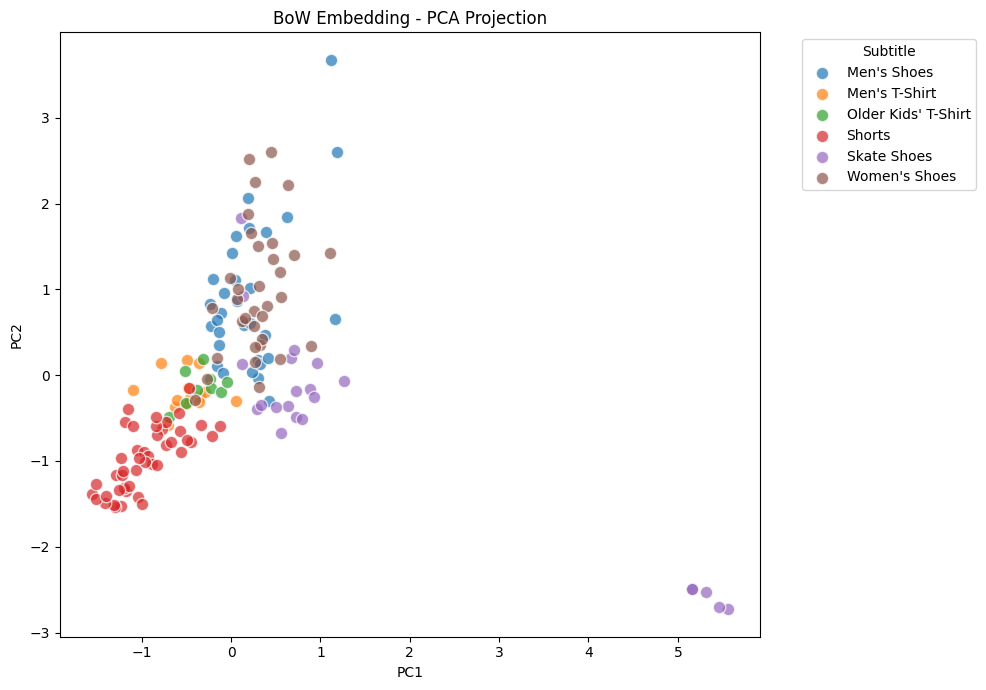

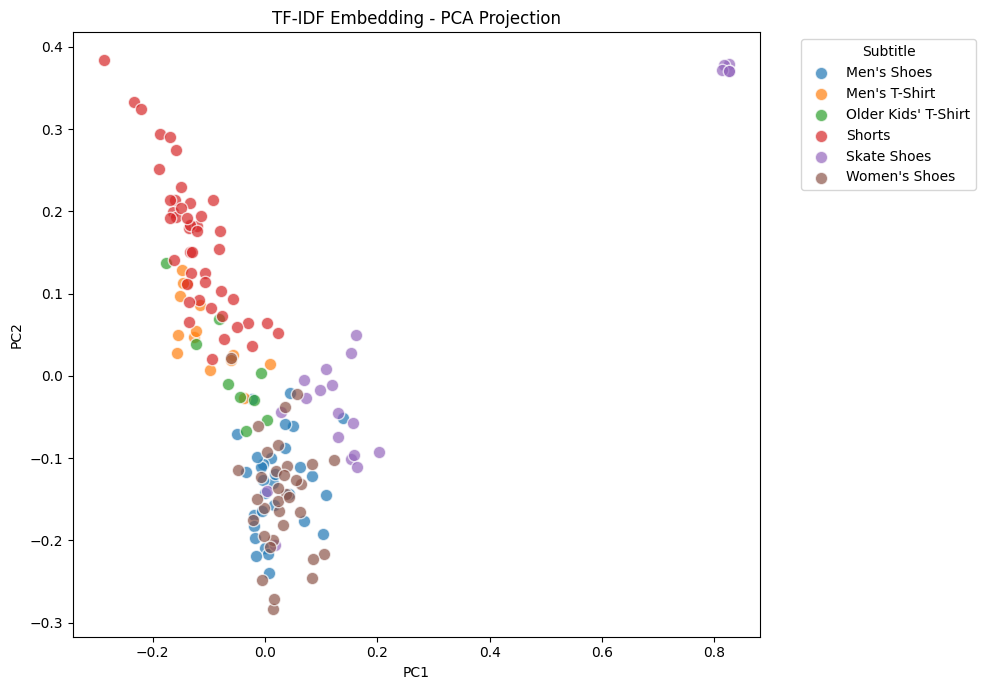

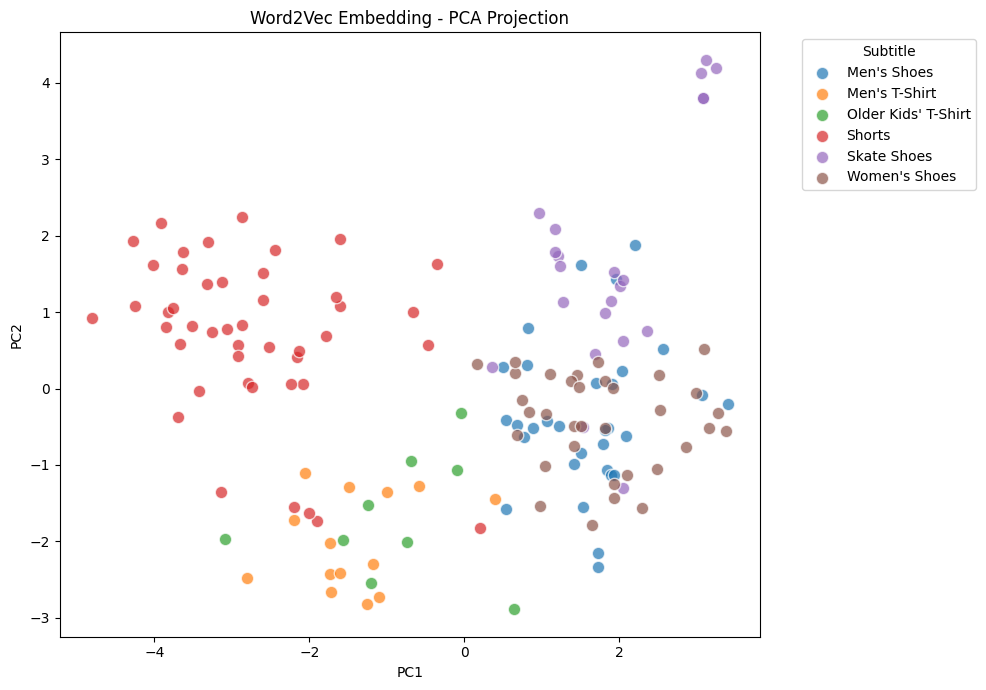

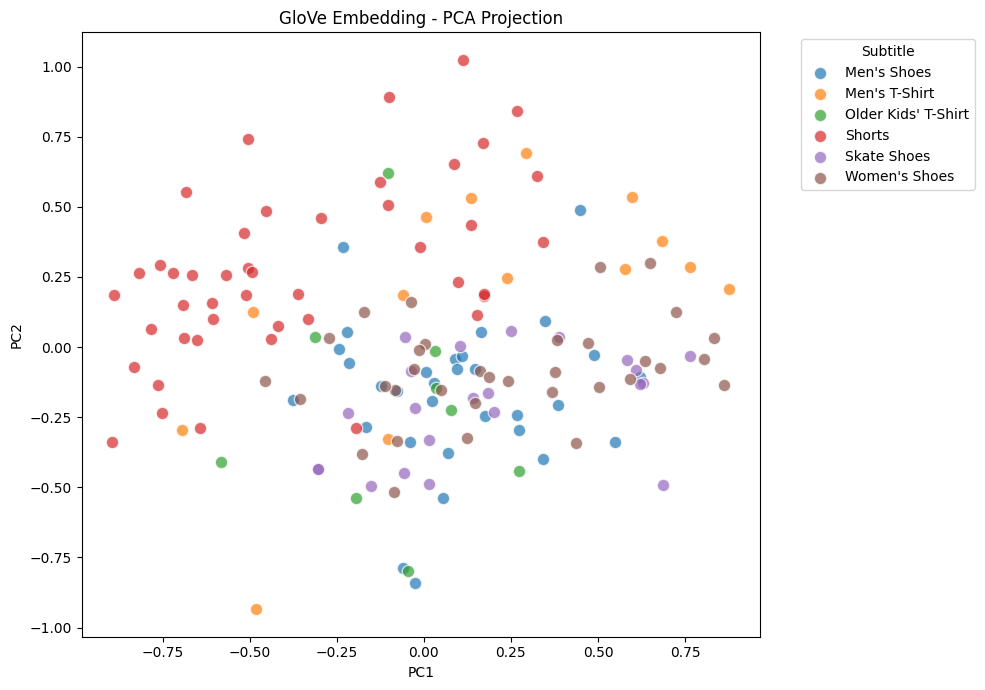

In [98]:
# PCA reduction to 2 components and plot
for name, emb in embedding_methods.items():
    pca = PCA(n_components=2)
    components = pca.fit_transform(emb)
    df['PC1'] = components[:, 0]
    df['PC2'] = components[:, 1]

    plt.figure(figsize=(10, 7))
    for subtitle, group in df.groupby('Subtitle'):
        plt.scatter(group['PC1'], group['PC2'], label=subtitle, alpha=0.7, edgecolors='w', s=80)
    plt.title(f'{name} Embedding - PCA Projection')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Subtitle', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Conclusion :
    # BoW and TF-IDF provide sparse vectors, but TF-IDF often shows clearer separation.
    # Word2Vec and GloVe provide denser and more semantic embeddings.
    # But Word2Vec seems to typically performs best in clustering similar products.